In [31]:
%pylab inline

import time

from scipy.signal import welch
from numpy.fft import fftshift

from scipy.signal import spectrogram

import pyvisa

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Pyro to communicate with board

import pickle
from pulse_lib.interpolate_phase import *
import Pyro4
from qick import *
Pyro4.config.SERIALIZER = "pickle"
Pyro4.config.PICKLE_PROTOCOL_VERSION=4

# Static IP proxy
ns_host = "172.24.106.21"
ns_port = 8888
proxy_name = "myqick"

# QICK object
ns = Pyro4.locateNS(host=ns_host, port=ns_port)
soc = Pyro4.Proxy(ns.lookup(proxy_name))
soccfg = QickConfig(soc.get_cfg())
print(soccfg)


QICK configuration:

	Board: RFSoC4x2

	Software version: 0.2.267
	Firmware timestamp: Wed Sep  6 18:49:29 2023

	Global clocks (MHz): tProcessor 409.600, RF reference 491.520

	2 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 0, blk 0 is DAC_B
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 2, blk 0 is DAC_A

	2 readout channels:
	0:	axis_readout_v2 - configured by PYNQ
		fs=4423.680 MHz, decimated=552.960 MHz, 32-bit DDS, range=4423.680 MHz
		maxlen 16384 accumulated, 1024 decimated (1.852 us)
		triggered by output 7, pin 14, feedback to tProc input 0
		ADC tile 0, blk 0 is ADC_D
	1:	axis_readout_v2 - configured by PYNQ
		fs=4423.680 MHz, decimated=552.960 MHz, 32-bit DDS, range=4423.680 MHz
		maxlen 16384 accumulated, 1024 decimated (1.852 us)
		triggered by o

In [3]:
# Import phase calibration data
with open('pickles/calibrate_phase.pickle', 'rb') as handle:
    delta_phis = pickle.load(handle)

In [4]:
def iq_mix_gens(iq_freq, phase, gain):
    # Config parameters
    freq = iq_freq
    phases = [phase, 0]
    gains = [10000, gain]

    # Program DAC registers
    prog = QickProgram(soccfg)
    soc.reset_gens()
    for ch in range(2):
        prog.declare_gen(ch=ch, nqz=1)
        prog.set_pulse_registers(ch = ch,
                                gain = gains[ch],
                                freq = prog.freq2reg(freq, gen_ch=ch),
                                phase = prog.deg2reg(phases[ch]+interpolate_phase(freq, delta_phis)[ch], gen_ch=ch),
                                style = "const",
                                length = prog.us2cycles(100, gen_ch=ch),
                                mode = "periodic",
                                )
        prog.pulse(ch=ch, t=0)

    # Start DACs
    prog.config_all(soc)
    soc.tproc.start()

In [5]:
def get_sum_diff_amplitudes(lo_freq, iq_freq):
    prog = QickProgram(soccfg)
    prog.declare_readout(ch=1, length=1000,
                        freq=0, gen_ch=1, sel="input")
    prog.trigger(mr=True)
    prog.config_all(soc)
    soc.arm_mr(ch=1)
    soc.tproc.start()

    iq_mr = soc.get_mr()

    # plt.plot(iq_mr[0:40,0])
    # plt.xlabel("sample number [ADC ticks]")
    # plt.show()

    fs_adc = soccfg['readouts'][1]['fs']
    fft_freqs, psd = welch(iq_mr[:,0], fs_adc, return_onesided=True, detrend=False, nperseg=512)

    # plt.semilogy(fft_freqs, psd)
    # # plt.plot(fft_freqs, psd)
    # plt.xlabel("absolute frequency [MHz]")
    # plt.ylabel("power [a.u.]");
    # plt.show()
    # print("Frequency:", fft_freqs[argmax(psd)], "MHz")

    diff_freq = lo_freq - iq_freq
    fft_dict = {}
    for i in range(len(fft_freqs)):
        fft_dict[fft_freqs[i]] = psd[i]

    ind = bisect.bisect_left(list(fft_dict.keys()), diff_freq)
    diff_freq_above = list(fft_dict.keys())[ind]
    diff_psd_above = fft_dict[list(fft_dict.keys())[ind]]
    diff_freq_below = list(fft_dict.keys())[ind-1]
    diff_psd_below = fft_dict[list(fft_dict.keys())[ind-1]]
    # print(diff_freq_above, diff_psd_above)
    # print(diff_freq_below, diff_psd_below)
    mean_diff_psd = (diff_psd_below + diff_psd_above) / 2

    return mean_diff_psd

In [32]:
LO_FREQ = 2000

rm = pyvisa.ResourceManager()
address = 'TCPIP0::172.24.106.20'
dev = rm.open_resource(address)
freq = "FREQ " + str(LO_FREQ * 1e6)
dev.write(freq)
# dev.write('POW 13') # set to 13 dBm
dev.close()

In [23]:
def calibrate_ssb(iq_freq, lo_freq, phases, gains):
    print(f"Calibrating {iq_freq}")

    phase_amplitudes_dict = {}
    for phase in phases:
        iq_mix_gens(iq_freq, phase, gain=10000)
        phase_amplitudes_dict[phase] = get_sum_diff_amplitudes(lo_freq, iq_freq)

    min_phase = min(phase_amplitudes_dict, key=phase_amplitudes_dict.get)

    gain_amplitudes_dict={}
    for gain in gains:
        iq_mix_gens(iq_freq, min_phase, gain)
        gain_amplitudes_dict[gain] = get_sum_diff_amplitudes(lo_freq, iq_freq)

    min_gain = min(gain_amplitudes_dict, key=gain_amplitudes_dict.get)

    return [min_phase, min_gain]

In [39]:
initial_iq = 500
initial_phases = np.arange(-180, 0, 1)
initial_gains = np.arange(0, 30000, 100)

initial_params = calibrate_ssb(initial_iq, LO_FREQ, initial_phases, initial_gains)

initial_phase = initial_params[0]
initial_gain = initial_params[1]
print(initial_gain)

Calibrating 500
5700


In [40]:
# initial_phase = -90
# initial_gain = 10000

In [43]:
low_freq = 50
high_freq = 1000
freq_step = 500

phase_range = 20
phase_step = 1

gain_range = 2000
gain_step = 100

iq_freqs = np.arange(low_freq, high_freq+freq_step, freq_step)
phases = np.arange(int(initial_phase-(phase_range/2)), int(initial_phase+(phase_range/2)+phase_step), phase_step)
gains = np.arange(int(initial_gain-(gain_range/2)), int(initial_gain+(gain_range/2)+gain_step), gain_step)

ssb_dict = {}

for iq_freq in iq_freqs:
    ssb_dict[iq_freq] = calibrate_ssb(iq_freq, LO_FREQ, phases, gains)

print(ssb_dict)

Calibrating 50
Calibrating 550
Calibrating 1050
{50: (-92, 10100), 550: (-90, 9900), 1050: (-99, 9300)}


In [32]:
lo_freq = 2000
iq_freqs = np.arange(950, 1060, 10)
ssb_dict = {}

for iq_freq in iq_freqs:
    print(f"Calibrating {iq_freq}")

    phases = np.arange(-95, -90, 0.1)
    phase_amplitudes_dict = {}
    for phase in phases:
        iq_mix_gens(iq_freq, phase, gain=10000)
        phase_amplitudes_dict[phase] = get_sum_diff_amplitudes(lo_freq, iq_freq)

    # x, y = [], []
    # for key, value in phase_amplitudes_dict.items():
    #     x.append(key)
    #     y.append(value)
    # plt.plot(x, y)
    # plt.title(f"{iq_freq} phase")
    # plt.show()

    min_phase = min(phase_amplitudes_dict, key=phase_amplitudes_dict.get)
    min_phase_amp = phase_amplitudes_dict[min_phase]

    gains = np.arange(9000, 11000, 25)
    gain_amplitudes_dict={}
    for gain in gains:
        iq_mix_gens(iq_freq, min_phase, gain)
        gain_amplitudes_dict[gain] = get_sum_diff_amplitudes(lo_freq, iq_freq)

    # x, y = [], []
    # for key, value in gain_amplitudes_dict.items():
    #     x.append(key)
    #     y.append(value)
    # plt.plot(x, y)
    # plt.title(f"{iq_freq} amplitude")
    # plt.show()

    min_gain = min(gain_amplitudes_dict, key=gain_amplitudes_dict.get)
    min_gain_amp = gain_amplitudes_dict[min_gain]

    ssb_dict[iq_freq] = [min_phase, min_gain]

print(ssb_dict)

Calibrating 950
Calibrating 960
Calibrating 970
Calibrating 980
Calibrating 990
Calibrating 1000
Calibrating 1010
Calibrating 1020
Calibrating 1030
Calibrating 1040
Calibrating 1050
{950: [-92.40000000000015, 9700], 960: [-92.10000000000016, 9625], 970: [-92.50000000000014, 9725], 980: [-92.20000000000016, 9825], 990: [-91.90000000000018, 9825], 1000: [-90.10000000000028, 9100], 1010: [-91.90000000000018, 9800], 1020: [-91.80000000000018, 9800], 1030: [-92.10000000000016, 9750], 1040: [-91.80000000000018, 9775], 1050: [-91.70000000000019, 9750]}


In [34]:
problem_freqs = []
for freq in iq_freqs:
    if abs(lo_freq - 2 * freq) == 0:
        try:
            del ssb_dict[freq]
            problem_freq = freq
        except KeyError:
            pass

In [12]:
# 172.24.106.20
# instrument

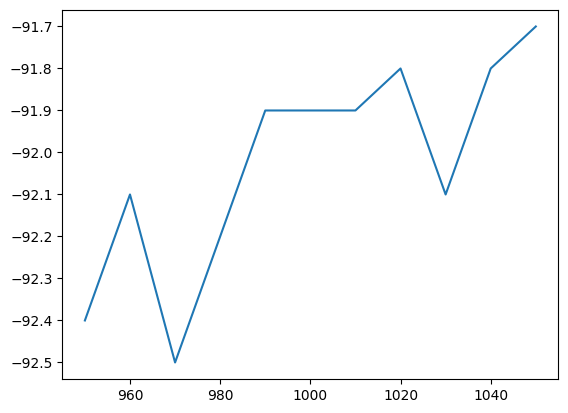

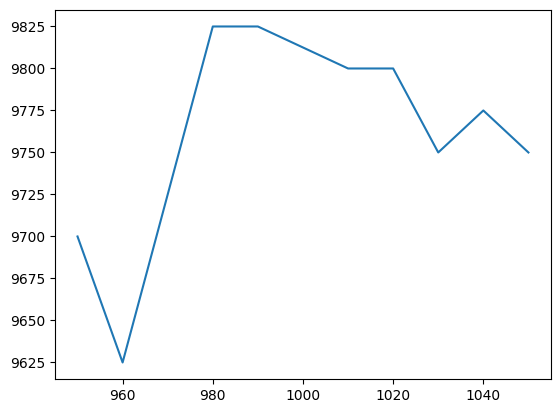

In [35]:
x, y1, y2 = [], [], []
for key, value in ssb_dict.items():
    y1.append(value[0])
    y2.append(value[1])
    x.append(key)

plt.plot(x, y1)
plt.show()

plt.plot(x, y2)
plt.show()

In [14]:
# # to save the data
# with open('pickles/ssb_params.pickle', 'wb') as handle:
#     pickle.dump(ssb_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
freqs = []
phases = []
amplitudes = []

ssb_dict[1000] = [-92.0, 9720]

for freq, params in ssb_dict.items():
    freqs.append(freq)
    phases.append(params[0])
    amplitudes.append(params[1])

degree = 20
phase_coeffs = np.polyfit(freqs, phases, degree)
phase_poly = np.poly1d(phase_coeffs)
amp_coeffs = np.polyfit(freqs, amplitudes, degree)
amp_poly = np.poly1d(amp_coeffs)

# Evaluate the polynomial at any value, e.g., x = 2.5
freq = 800
test_phase = phase_poly(freq)
test_amp = amp_poly(freq)

print(test_phase, test_amp)

-91.66491625267214 9747.011109115396


c:\Users\micro\qeg-rfsoc\.venv\lib\site-packages\IPython\core\interactiveshell.py:3550: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\micro\qeg-rfsoc\.venv\lib\site-packages\IPython\core\interactiveshell.py:3550: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


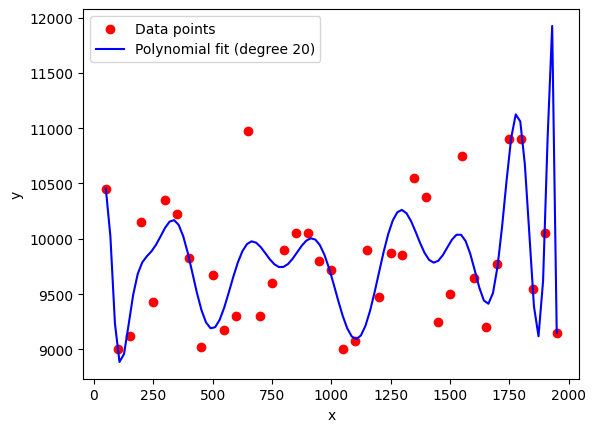

In [16]:
x_fit = np.linspace(min(freqs), max(freqs), 100)
y_fit = amp_poly(x_fit)

plt.scatter(freqs, amplitudes, color='red', label='Data points')
plt.plot(x_fit, y_fit, color='blue', label=f'Polynomial fit (degree {degree})')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [17]:
# Config parameters
freq = 1010
phases = [ssb_dict[freq][0], 0]
gains = [10000, ssb_dict[freq][1]]

# Program DAC registers
prog = QickProgram(soccfg)
soc.reset_gens()
for ch in range(2):
    prog.declare_gen(ch=ch, nqz=1)
    prog.set_pulse_registers(ch = ch,
                             gain = gains[ch],
                             freq = prog.freq2reg(freq, gen_ch=ch),
                             phase = prog.deg2reg(phases[ch]+interpolate_phase(freq, delta_phis)[ch], gen_ch=ch),
                             style = "const",
                             length = prog.us2cycles(100, gen_ch=ch),
                             mode = "periodic",
                            )
    prog.pulse(ch=ch, t=0)

# Start DACs
prog.config_all(soc)
soc.tproc.start()

KeyError: 1010

In [19]:
# Config parameters
freq = 400
phases = [phase_poly(freq), 0]
gains = [10000, int(amp_poly(freq))]

# Program DAC registers
prog = QickProgram(soccfg)
soc.reset_gens()
for ch in range(2):
    prog.declare_gen(ch=ch, nqz=1)
    prog.set_pulse_registers(ch = ch,
                             gain = gains[ch],
                             freq = prog.freq2reg(freq, gen_ch=ch),
                             phase = prog.deg2reg(phases[ch]+interpolate_phase(freq, delta_phis)[ch], gen_ch=ch),
                             style = "const",
                             length = prog.us2cycles(100, gen_ch=ch),
                             mode = "periodic",
                            )
    prog.pulse(ch=ch, t=0)

# Start DACs
prog.config_all(soc)
soc.tproc.start()